<a href="https://colab.research.google.com/github/JordiPG05/Curso-Yolo/blob/main/Non_Max_Suppression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Supresión no máxima**

#### En este tutorial de ejemplo se van a cargar una predicciones de un modelo de CNN y se van a simplificar escogiendo la mejor region utilizando la tecnia de non Max Supression.

  
#Los objetos en la imagen pueden ser de diferentes tamaños y formas. Para capturar perfectamente cada uno de los objetos. El algoritmo de detección de objetos crea múltiples cajas delimitadoras alrededor de cada objeto detectado. Idealmente, para cada objeto de la imagen debemos tener un único cuadro delimitador. Para seleccionar el mejor cuadro delimitador de entre los predecidos, estos algoritmos de detección utilizan la Supresión No Máxima.

##**Veamos qué es la Supresión No Máxima.**

#Non Max Supression toma todos los cuadros delimitadores pronosticados alrededor de un objeto dado y devuelve el mejor cuadro delimitador pronosticado.

Queremos que a partir de las predicciones de la imagen superior obtengamos un cuadro delimitador como el inferior.

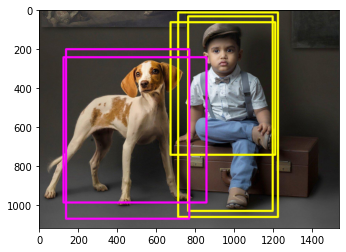

image.png

#**Entendamos el proceso de selección de la mejor caja delimitadora usando Non Max Supression (NMS)**

1. Primero tomaremos todas las predicciones y luego seleccionaremos la casilla con mayor puntuación de probabilidad

2. A continuación comparamos el solapamiento del cuadro delimitador seleccionado con el resto de los cuadros delimitadores

3. A continuación, podemos eliminar el cuadro delimitador que tenga un solapamiento superior al valor umbral.

4. Repita este proceso.

#**Import all the Required Libraries**

In [1]:
# Import required Modules
import cv2
import torch
import matplotlib.pyplot as plt

#**Creamos una función con el nombre leer_predicciones usando esta función leeremos el fichero predicciones.txt línea a línea**

In [2]:
# Funcion de carga de predicciones
def read_predictions(filepath):
    with open(filepath) as f:
        return f.readlines()

In [3]:
# Descargamos las predicciones de ejemplo
!gdown "https://drive.google.com/uc?id=1HMzwz3LzjYqhDQNX-35NOsUJp4rBcmN0&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1HMzwz3LzjYqhDQNX-35NOsUJp4rBcmN0&confirm=t
To: /content/Predictions.txt
100% 117/117 [00:00<00:00, 485kB/s]


In [4]:
# Cragamos las predicciones
prediction = read_predictions('/content/Predictions.txt')

In [5]:
prediction

['673,62,1209,740,0,0.89\n',
 '763,32,1196,1027,0,0.95\n',
 '712,12,1223,1058,0,0.99\n',
 '125,241,857,984,1,0.90\n',
 '138,200,769,1067,1,0.95']

#**Hasta ahora hemos leído todas las predicciones en el archivo Predictions.txt, ahora vamos a limpiar y procesar estas predicciones y convertir estas predicciones en un formato adecuado**

In [6]:
#Corregimos errores de lectura como los '\n' y creamos una lista con el 
# vector de 6 elementos

def process_predictions(predictions):
    processed_predictions = []
    for prediction in predictions:
        prediction = prediction.split(',')
        prediction = [
            
            float(elem.replace('\n', '')) if prediction.index(elem) == 5
            else int(elem.replace('\n', '')) 
            for elem in prediction
        ]
        processed_predictions.append(prediction)
    return processed_predictions
        

In [7]:
# Aplicamos la funcion de limpieza
predictions = process_predictions(prediction)

In [8]:
predictions

[[673, 62, 1209, 740, 0, 0.89],
 [763, 32, 1196, 1027, 0, 0.95],
 [712, 12, 1223, 1058, 0, 0.99],
 [125, 241, 857, 984, 1, 0.9],
 [138, 200, 769, 1067, 1, 0.95]]

In [9]:
# Observamos las distintas clases (posicion 4)
for prediction in predictions:
  print(prediction[4])

0
0
0
1
1


In [10]:
# Observamos el X1 del cuadro (posicion 0 y 1)
for prediction in predictions:
  print(prediction[0:2])

[673, 62]
[763, 32]
[712, 12]
[125, 241]
[138, 200]


#**Visualización de una imagen de entrada de ejemplo**

In [11]:
# Descargamos la imagen de test
!gdown "https://drive.google.com/uc?id=1KLntO-rLPPLnzI9FmQ9MAg5P1ngdr6W0&confirm=t"


Downloading...
From: https://drive.google.com/uc?id=1KLntO-rLPPLnzI9FmQ9MAg5P1ngdr6W0&confirm=t
To: /content/Person_and_Dog.jpg
100% 202k/202k [00:00<00:00, 64.5MB/s]


In [12]:
# Cargamos y vemos la iamgen
img = cv2.imread('/content/Person_and_Dog.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [13]:
# Definimos los colores para la clase
Color_map = {
    0:(255,255,0),
    1:(255,0,255)
}
# Funcion de pitar cuadros
def draw_boxes(img, predictions):
    for prediction in predictions:
        color = Color_map[prediction[4]]
        cv2.rectangle(img, prediction[0:2], prediction[2:4], color, 10)
    return img
        

In [14]:
# Vissualizamos los cuadros segun su clase
img = draw_boxes(img, predictions)
plt.imshow(img)
plt.show()

In [15]:
# Funcion de calculo de las IOU
def calculate_IOU(preds, labels):
    preds_x1 = preds[..., 0:1]
    preds_y1 = preds[..., 1:2]
    preds_x2 = preds[..., 2:3]
    preds_y2 = preds[..., 3:4]
    
    labels_x1 = labels[..., 0:1]
    labels_y1 = labels[..., 1:2]
    labels_x2 = labels[..., 2:3]
    labels_y2 = labels[..., 3:4]
    
    x1 = torch.max(preds_x1, labels_x1)
    y1 = torch.max(preds_y1, labels_y1)
    
    x2 = torch.min(preds_x2, labels_x2)
    y2 = torch.min(preds_y2, labels_y2)
    
    area_of_intersection = (x2-x1).clamp(0) * (y2-y1).clamp(0)
    
    preds_area = abs((preds_x2 - preds_x1) * (preds_y2 - preds_y1))
    labels_area = abs((labels_x2 - labels_x1) * (labels_y2 - labels_y1))
    
    area_of_union = preds_area + labels_area - area_of_intersection
    
    return area_of_intersection / area_of_union

In [16]:
# Creating Non Max Supression
# Indicamos los cuadros de entrada, el threshold de probabilidad de los cuadros de entrada y el threshold de las IOU
def non_max_supression(boxes, prob_threshold=0.3, iou_threshold=0.6):

    filtered_boxes = []
    final_boxes = []
    sorted_boxes = sorted(boxes, reverse=True, key = lambda x : x[5])
    print("Sorted Boxes",sorted_boxes)
    for box in sorted_boxes:
        print("Box[5]",box[5])
        if box[5] > prob_threshold:
            filtered_boxes.append(box)
    print("Box", filtered_boxes)
    print("Length of the Filtered Boxes", len(filtered_boxes))
    while len(filtered_boxes) > 0:
        current_box = filtered_boxes.pop(0)
        print("Current Box", current_box)
        for box in filtered_boxes:
            print("Box", box)
            print("Current Box [4]", current_box[4])
            print("Box [4]", box[4])
            if current_box[4] == box[4]:
                iou = calculate_IOU(torch.Tensor(current_box[:4]), torch.Tensor(box[:4]))
                if iou > iou_threshold:
                    print("Box", box)
                    print("-----------")
                    filtered_boxes.remove(box)   
        
        final_boxes.append(current_box)
        
    return final_boxes


In [17]:
# Aplicamos la función
nmspredictions = non_max_supression(predictions)

Sorted Boxes [[712, 12, 1223, 1058, 0, 0.99], [763, 32, 1196, 1027, 0, 0.95], [138, 200, 769, 1067, 1, 0.95], [125, 241, 857, 984, 1, 0.9], [673, 62, 1209, 740, 0, 0.89]]
Box[5] 0.99
Box[5] 0.95
Box[5] 0.95
Box[5] 0.9
Box[5] 0.89
Box [[712, 12, 1223, 1058, 0, 0.99], [763, 32, 1196, 1027, 0, 0.95], [138, 200, 769, 1067, 1, 0.95], [125, 241, 857, 984, 1, 0.9], [673, 62, 1209, 740, 0, 0.89]]
Length of the Filtered Boxes 5
Current Box [712, 12, 1223, 1058, 0, 0.99]
Box [763, 32, 1196, 1027, 0, 0.95]
Current Box [4] 0
Box [4] 0
Box [763, 32, 1196, 1027, 0, 0.95]
-----------
Box [125, 241, 857, 984, 1, 0.9]
Current Box [4] 0
Box [4] 1
Box [673, 62, 1209, 740, 0, 0.89]
Current Box [4] 0
Box [4] 0
Box [673, 62, 1209, 740, 0, 0.89]
-----------
Current Box [138, 200, 769, 1067, 1, 0.95]
Box [125, 241, 857, 984, 1, 0.9]
Current Box [4] 1
Box [4] 1
Box [125, 241, 857, 984, 1, 0.9]
-----------


In [18]:
# Obtenemos la mejor IOU de cada clase
nmspredictions

[[712, 12, 1223, 1058, 0, 0.99], [138, 200, 769, 1067, 1, 0.95]]

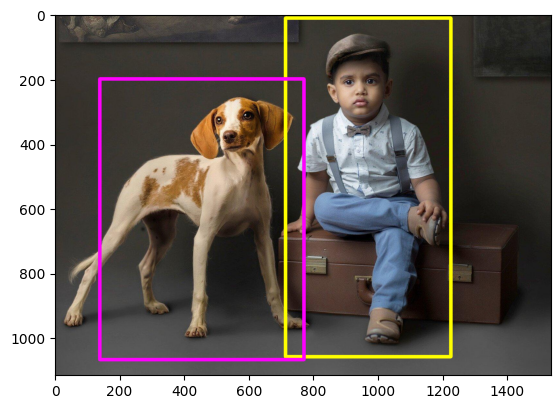

In [19]:
# Visualizamos el resultado
img = cv2.imread('/content/Person_and_Dog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_boxes(img, nmspredictions )
plt.imshow(img)
plt.show()